In [1]:
import time
import psutil

In [2]:
# start_time = time.time()

# cpu_before = psutil.cpu_percent(interval=1)

# memory_before = psutil.virtual_memory().used

# disk_before = psutil.disk_usage(r'C:\Users\user\Desktop\OKUL\GUZ_23-24\MAT381-Introduction_to_datascience\MAT381-IntroductionToDataScience\final_project').used

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from IPython.display import display
from datapackage import Package
import requests
import duckdb
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy import stats
import statsmodels.api as sm
from scipy.spatial.distance import correlation
from scipy.signal import correlate
import pingouin as pg
import seaborn as sns
from numpy.fft import rfft
import pycountry

# Fınal Project-The Investigation of the relationship Between Covid-19 Cases and Air Quality

## Introduction
This project will examine the relationship between COVID-19 and air quality over time and location.
### Earlier Studies
**Temperature**:
Some studies suggest a *negative* association between temperature and COVID-19 transmission, meaning warmer temperatures might see lower spread. However, other studies haven't found a clear link.
( https://pubmed.ncbi.nlm.nih.gov/32361460/ ,  https://www.scirp.org/journal/paperinformation?paperid=124973)\
\
**Humidity**:
Research on humidity is *inconclusive*, with some studies suggesting either a positive or negative association with COVID-19 transmission. Higher humidity might trap virus particles but also favor outdoor activities, influencing transmission dynamics.
( https://link.springer.com/article/10.1007/s10668-020-00933-5 , https://www.sciencedirect.com/science/article/pii/S0738059322000311)\
\
**Wind Speed**:Higher wind speed generally disperses virus particles, potentially reducing transmission. However, strong winds can also promote dust and aerosol movement, possibly carrying the virus.
( https://pubmed.ncbi.nlm.nih.gov/34813801/ , https://link.springer.com/article/10.1007/s10668-020-00933-5)\
\
**PM2.5**:*Higher* PM2.5 levels, a type of air pollution, are often associated with increased COVID-19 cases and severity. This could be due to impaired lung function and increased susceptibility to respiratory infections.
( https://pubmed.ncbi.nlm.nih.gov/34813801/ , https://link.springer.com/article/10.1007/s10668-020-00933-5)\
\
**Dew Point**:The relationship between dew point and COVID-19 is *less studied*, but some research suggests a *possible positive association* with transmission at higher dew points.
( https://www.scirp.org/journal/paperinformation?paperid=124973)\
\
**Pressure**:Research on the link between air pressure and COVID-19 is *limited*, with some studies suggesting a *negative association* between higher pressure and transmission.
( https://pubmed.ncbi.nlm.nih.gov/32361460/)
\
\
It's crucial to remember these are potential correlations, not causal relationships. Numerous other factors, including human behavior, population density, and public health measures, significantly impact COVID-19 transmission.
Research findings can vary depending on location, climate, and study methodology.



## Data Preprocessing
### Datasets
* air quality([https://aqicn.org/data-platform/covid19/verify/a99b8b95-a551-4e6b-a1a2-901fb841c707](https://aqicn.org/data-platform/covid19/verify/a99b8b95-a551-4e6b-a1a2-901fb841c707))
* covid cases([https://covid19.who.int/data](https://covid19.who.int/data))
* country polygons([https://datahub.io/core/geo-countries#python](https://datahub.io/core/geo-countries#python))

In [4]:
airq_data = pd.read_csv('waqi-covid19-airqualitydata-2021Q1.csv', skiprows=4)
airq_df=pd.DataFrame(airq_data)
airq_df.head()

,Date,Country,City,Specie,count,min,max,median,variance
0,2021-04-04,CN,Beijing,pressure,288,1022.0,1028.0,1026.0,48.39
1,2021-02-13,CN,Beijing,pressure,288,1018.0,1022.5,1021.0,23.31
2,2021-02-16,CN,Beijing,pressure,288,1018.0,1030.0,1026.0,150.71
3,2021-03-01,CN,Beijing,pressure,288,1026.5,1032.0,1028.5,25.09
4,2021-03-14,CN,Beijing,pressure,288,1010.5,1019.0,1015.5,93.17


In [5]:
covid_data = pd.read_csv('WHO-COVID-19-global-data.csv')
covid_df=pd.DataFrame(covid_data)
covid_df.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0


We will take necessary columns, and rename related ones:

In [6]:
reduced_covid = covid_df[['Date_reported','Country_code','New_cases']]
reduced_covid.rename(columns={'Country_code':'Country','Date_reported':'Date'},inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_29972\1509120219.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_covid.rename(columns={'Country_code':'Country','Date_reported':'Date'},inplace=True)


Checking NaN values:

In [7]:
print(f'Number of null values:\nCovid data: {reduced_covid.isna().sum().sum()}\nAir data: {airq_df.isna().sum().sum()}')

Number of null values:
Covid data: 1407
Air data: 0


We will analyse the data based on countries, but the air quality data is based on cities. Thus we will group them by Countries, and take the mean values of medians of cities as a country value. There are min	max	median and	variance values but taking median values as a reference will be better:

In [8]:
grouped_df = airq_df.groupby(["Date", "Country", "Specie"])
# Calculate the mean of median values for each group
grouped_airq_df = grouped_df["median"].mean().reset_index()
grouped_airq_df

,Date,Country,Specie,median
0,2020-12-28,AE,co,0.100000
1,2020-12-28,AE,dew,9.500000
2,2020-12-28,AE,humidity,50.000000
3,2020-12-28,AE,no2,15.100000
4,2020-12-28,AE,o3,12.000000
...,...,...,...,...
90655,2021-04-04,ZA,so2,1.400000
90656,2021-04-04,ZA,temperature,19.183333
90657,2021-04-04,ZA,wd,225.000000
90658,2021-04-04,ZA,wind-gust,6.966667


Now, we will seperate species as columns:

In [9]:
pivoted_airq = duckdb.sql("""
    pivot grouped_airq_df on Specie
        using sum(median) as value
        group by Date,Country
        order by Date,Country
""").to_df()

In [10]:
pivoted_airq

,Date,Country,aqi_value,co_value,dew_value,humidity_value,mepaqi_value,neph_value,no2_value,o3_value,...,pm10_value,pm25_value,precipitation_value,pressure_value,so2_value,temperature_value,uvi_value,wd_value,wind-gust_value,wind-speed_value
0,2020-12-28,AE,NaN,0.100000,9.500000,50.000000,NaN,NaN,15.100000,12.000000,...,100.000000,48.500000,NaN,1019.000000,4.600,20.500000,NaN,NaN,NaN,2.750000
1,2020-12-28,AF,NaN,NaN,-15.000000,35.000000,NaN,NaN,NaN,NaN,...,NaN,102.000000,NaN,1019.000000,NaN,-2.000000,NaN,NaN,NaN,3.600000
2,2020-12-28,AR,NaN,2.800000,20.700000,75.100000,NaN,NaN,14.200000,3.300000,...,19.000000,25.000000,NaN,1012.000000,NaN,25.800000,NaN,90.0,13.000000,5.600000
3,2020-12-28,AT,NaN,0.100000,-3.380000,71.740000,NaN,NaN,10.000000,NaN,...,13.400000,42.500000,74.425,984.480000,1.100,1.320000,NaN,NaN,10.833333,4.480000
4,2020-12-28,AU,NaN,2.071429,11.954545,62.900000,NaN,11.0,2.122222,9.775000,...,12.272727,17.545455,97.150,1007.209091,2.300,20.145455,NaN,152.7,9.088889,3.836364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8961,2021-04-04,US,NaN,2.702381,2.325000,49.632143,NaN,NaN,6.737209,28.264815,...,24.518519,38.392857,NaN,1008.123214,0.915,14.712500,NaN,151.5,5.558182,2.712500
8962,2021-04-04,UZ,NaN,NaN,9.000000,74.500000,NaN,NaN,NaN,NaN,...,NaN,93.000000,NaN,1007.000000,NaN,12.000000,NaN,NaN,NaN,2.500000
8963,2021-04-04,VN,115.0,5.000000,23.900000,86.575000,NaN,NaN,10.100000,5.500000,...,45.000000,73.000000,NaN,1007.275000,8.000,25.650000,NaN,NaN,NaN,2.325000
8964,2021-04-04,XK,NaN,16.700000,0.000000,83.000000,NaN,NaN,6.600000,23.400000,...,12.000000,53.000000,NaN,1015.000000,1.300,2.000000,NaN,NaN,NaN,1.500000


Checking NaN values:

In [11]:
pivoted_airq.isna().sum()

Date                      0
Country                   0
aqi_value              8679
co_value               3580
dew_value               946
humidity_value           50
mepaqi_value           8868
neph_value             8868
no2_value              3095
o3_value               3341
pm1_value              8835
pm10_value             2500
pm25_value              584
precipitation_value    7400
pressure_value           50
so2_value              2973
temperature_value        50
uvi_value              8672
wd_value               8003
wind-gust_value        3130
wind-speed_value         70
dtype: int64

We have almost 9k data. When we look at the NaN counts, we realize that, if we manipulate the columns whos almost 1/3 are empty, it will affect the accuracy of analyze. Thus, we have to eliminate the parameters which has more than 2500 NaN values:

In [12]:
reduced_airq = pivoted_airq.loc[:, (pivoted_airq.isna().sum() < 2500)]

In [13]:
reduced_airq

,Date,Country,dew_value,humidity_value,pm25_value,pressure_value,temperature_value,wind-speed_value
0,2020-12-28,AE,9.500000,50.000000,48.500000,1019.000000,20.500000,2.750000
1,2020-12-28,AF,-15.000000,35.000000,102.000000,1019.000000,-2.000000,3.600000
2,2020-12-28,AR,20.700000,75.100000,25.000000,1012.000000,25.800000,5.600000
3,2020-12-28,AT,-3.380000,71.740000,42.500000,984.480000,1.320000,4.480000
4,2020-12-28,AU,11.954545,62.900000,17.545455,1007.209091,20.145455,3.836364
...,...,...,...,...,...,...,...,...
8961,2021-04-04,US,2.325000,49.632143,38.392857,1008.123214,14.712500,2.712500
8962,2021-04-04,UZ,9.000000,74.500000,93.000000,1007.000000,12.000000,2.500000
8963,2021-04-04,VN,23.900000,86.575000,73.000000,1007.275000,25.650000,2.325000
8964,2021-04-04,XK,0.000000,83.000000,53.000000,1015.000000,2.000000,1.500000


for the remaining columns, let us know about their meanings:

###  Meanings of Air Quality and Weather Data Variables

**Air Quality Variables:**

* **pm25 (particulate matter ≤ 2.5 micrometers):**
    * Tiny particles smaller particles than PM10 that lodge deep in the lungs.
    * Can cause respiratory problems and heart disease.
    * Pose even greater health risks due to deeper lung penetration.

**Weather Variables:**

* **dew (dew point):**
    * Temperature at which water vapor condenses into liquid water.
    * Higher dew points indicate higher humidity and more likely dew or fog.
* **humidity:**
    * Amount of water vapor in the air as a percentage of its capacity.
    * Higher humidity can feel uncomfortable and hinder exercise.
* **pressure (atmospheric pressure):**
    * Force exerted by the weight of the air above.
    * Higher pressure generally means fair weather.
    * Lower pressure can indicate approaching storms.
* **temperature:**
    * Degree of hotness or coldness of the air.
* **wind-speed:**
    * Speed at which the air is moving.
    * Affects outdoor activities and contributes to heat loss or wind chill.

In [14]:
reduced_airq.isna().sum()

Date                   0
Country                0
dew_value            946
humidity_value        50
pm25_value           584
pressure_value        50
temperature_value     50
wind-speed_value      70
dtype: int64

In [15]:
reduced_airq

,Date,Country,dew_value,humidity_value,pm25_value,pressure_value,temperature_value,wind-speed_value
0,2020-12-28,AE,9.500000,50.000000,48.500000,1019.000000,20.500000,2.750000
1,2020-12-28,AF,-15.000000,35.000000,102.000000,1019.000000,-2.000000,3.600000
2,2020-12-28,AR,20.700000,75.100000,25.000000,1012.000000,25.800000,5.600000
3,2020-12-28,AT,-3.380000,71.740000,42.500000,984.480000,1.320000,4.480000
4,2020-12-28,AU,11.954545,62.900000,17.545455,1007.209091,20.145455,3.836364
...,...,...,...,...,...,...,...,...
8961,2021-04-04,US,2.325000,49.632143,38.392857,1008.123214,14.712500,2.712500
8962,2021-04-04,UZ,9.000000,74.500000,93.000000,1007.000000,12.000000,2.500000
8963,2021-04-04,VN,23.900000,86.575000,73.000000,1007.275000,25.650000,2.325000
8964,2021-04-04,XK,0.000000,83.000000,53.000000,1015.000000,2.000000,1.500000


For the missing values, we should do interpolation, but we must remember that air parameters generally based on ocations. So we should do the interpolation within the country data.

In [16]:
grouped = reduced_airq.groupby('Country')

# Define a function to perform interpolation by country
def interpolate_country(group):
    # Sort values by date within each country
    group = group.sort_values('Date')
    # Interpolate missing values within the group based on date
    group = group.interpolate(method='linear', limit_direction='both') # linear because daily data would not change nonlineraly
    return group

# Apply the interpolation function to each group and concatenate the results
interpolated_data = grouped.apply(interpolate_country)

# Reset the index of the concatenated DataFrame
interpolated_data = interpolated_data.reset_index(drop=True)

# Return the resulting DataFrame with interpolated values
interpolated_data

,Date,Country,dew_value,humidity_value,pm25_value,pressure_value,temperature_value,wind-speed_value
0,2020-12-28,AE,9.500000,50.000000,48.500000,1019.000000,20.500000,2.750000
1,2020-12-28,AF,-15.000000,35.000000,102.000000,1019.000000,-2.000000,3.600000
2,2020-12-28,AR,20.700000,75.100000,25.000000,1012.000000,25.800000,5.600000
3,2020-12-28,AT,-3.380000,71.740000,42.500000,984.480000,1.320000,4.480000
4,2020-12-28,AU,11.954545,62.900000,17.545455,1007.209091,20.145455,3.836364
...,...,...,...,...,...,...,...,...
8961,2021-04-04,US,2.325000,49.632143,38.392857,1008.123214,14.712500,2.712500
8962,2021-04-04,UZ,9.000000,74.500000,93.000000,1007.000000,12.000000,2.500000
8963,2021-04-04,VN,23.900000,86.575000,73.000000,1007.275000,25.650000,2.325000
8964,2021-04-04,XK,0.000000,83.000000,53.000000,1015.000000,2.000000,1.500000


In [17]:
interpolated_data.isna().sum()

Date                   0
Country                0
dew_value            672
humidity_value         0
pm25_value           294
pressure_value         0
temperature_value      0
wind-speed_value       0
dtype: int64

Missing values might be related to specific countries. Thus let us check:

In [18]:
suspected_countries=interpolated_data[interpolated_data['pm25_value'].isna()]['Country'].unique()
print(suspected_countries)
interpolated_data[interpolated_data['Country'].isin(suspected_countries)]

['BG' 'JO' 'MY']


,Date,Country,dew_value,humidity_value,pm25_value,pressure_value,temperature_value,wind-speed_value
8,2020-12-28,BG,6.333333,82.000000,NaN,1008.333333,9.266667,2.966667
44,2020-12-28,JO,4.000000,80.000000,NaN,1022.000000,7.000000,2.500000
58,2020-12-28,MY,24.192308,83.207692,NaN,1008.238462,27.307692,1.823077
96,2020-12-29,BG,4.666667,63.733333,NaN,1009.333333,11.666667,4.733333
132,2020-12-29,JO,4.000000,75.000000,NaN,1021.000000,8.000000,1.500000
...,...,...,...,...,...,...,...,...
8827,2021-04-03,JO,5.000000,71.000000,NaN,1021.000000,10.000000,4.100000
8841,2021-04-03,MY,24.423077,80.923077,NaN,1007.153846,27.961538,1.723077
8881,2021-04-04,BG,4.333333,81.366667,NaN,1013.233333,6.800000,4.166667
8920,2021-04-04,JO,3.000000,47.000000,NaN,1022.000000,14.000000,2.000000


As we can see 3 countries('BG' 'JO' 'MY') do not have an pm25 data(exactly 294 data), as the data is crucial, instead of removing the pm25 data, we will remove these 3 countries.

In [19]:
interpolated_data = interpolated_data[~interpolated_data['Country'].isin(suspected_countries)]
interpolated_data.isna().sum()

Date                   0
Country                0
dew_value            672
humidity_value         0
pm25_value             0
pressure_value         0
temperature_value      0
wind-speed_value       0
dtype: int64

In [20]:
suspected_countries2=interpolated_data[interpolated_data['dew_value'].isna()]['Country'].unique()
suspected_countries2

array(['CR', 'DK', 'HK', 'IE', 'KW', 'PE', 'PR'], dtype=object)

In [21]:
interpolated_data[interpolated_data['Country'].isin(suspected_countries2)]

,Date,Country,dew_value,humidity_value,pm25_value,pressure_value,temperature_value,wind-speed_value
16,2020-12-28,CR,NaN,62.1,17.0,1013.6,19.1,5.6
20,2020-12-28,DK,NaN,79.0,44.0,984.4,4.2,5.0
33,2020-12-28,HK,NaN,68.0,69.0,1014.6,20.5,2.5
37,2020-12-28,IE,NaN,88.2,15.0,980.2,4.1,6.5
48,2020-12-28,KW,NaN,61.5,80.0,1026.2,13.8,3.3
...,...,...,...,...,...,...,...,...
8909,2021-04-04,HK,NaN,78.0,62.0,1014.9,25.5,3.5
8913,2021-04-04,IE,NaN,74.0,40.0,1029.5,9.4,5.5
8924,2021-04-04,KW,NaN,45.7,50.0,1020.2,21.7,7.2
8939,2021-04-04,PE,NaN,69.2,60.0,996.8,23.1,1.0


We should do the same thing for these 6 countries('CR', 'DK', 'IE', 'KW', 'PE', 'PR') too.

In [22]:
interpolated_data = interpolated_data[~interpolated_data['Country'].isin(suspected_countries2)]
interpolated_data = interpolated_data.reset_index(drop=True)
interpolated_data.isna().sum()

Date                 0
Country              0
dew_value            0
humidity_value       0
pm25_value           0
pressure_value       0
temperature_value    0
wind-speed_value     0
dtype: int64

Now, we are all clear, preprocessed air quality data:

In [23]:
interpolated_data

,Date,Country,dew_value,humidity_value,pm25_value,pressure_value,temperature_value,wind-speed_value
0,2020-12-28,AE,9.500000,50.000000,48.500000,1019.000000,20.500000,2.750000
1,2020-12-28,AF,-15.000000,35.000000,102.000000,1019.000000,-2.000000,3.600000
2,2020-12-28,AR,20.700000,75.100000,25.000000,1012.000000,25.800000,5.600000
3,2020-12-28,AT,-3.380000,71.740000,42.500000,984.480000,1.320000,4.480000
4,2020-12-28,AU,11.954545,62.900000,17.545455,1007.209091,20.145455,3.836364
...,...,...,...,...,...,...,...,...
7995,2021-04-04,US,2.325000,49.632143,38.392857,1008.123214,14.712500,2.712500
7996,2021-04-04,UZ,9.000000,74.500000,93.000000,1007.000000,12.000000,2.500000
7997,2021-04-04,VN,23.900000,86.575000,73.000000,1007.275000,25.650000,2.325000
7998,2021-04-04,XK,0.000000,83.000000,53.000000,1015.000000,2.000000,1.500000


Now, let us look at covid data. We can analyze common countries and dates of two dataframes:

In [24]:
common_countries = list(set(interpolated_data['Country']).intersection(set(reduced_covid['Country'])))
common_dates = list(set(interpolated_data['Date']).intersection(set(reduced_covid['Date'])))

final_airq = interpolated_data[(interpolated_data['Date'].isin(common_dates)) & (interpolated_data['Country'].isin(common_countries))]
final_covid = reduced_covid[(reduced_covid['Date'].isin(common_dates)) & (reduced_covid['Country'].isin(common_countries))]

In [25]:
final_airq.head()

,Date,Country,dew_value,humidity_value,pm25_value,pressure_value,temperature_value,wind-speed_value
0,2020-12-28,AE,9.500000,50.00,48.500000,1019.000000,20.500000,2.750000
1,2020-12-28,AF,-15.000000,35.00,102.000000,1019.000000,-2.000000,3.600000
2,2020-12-28,AR,20.700000,75.10,25.000000,1012.000000,25.800000,5.600000
3,2020-12-28,AT,-3.380000,71.74,42.500000,984.480000,1.320000,4.480000
4,2020-12-28,AU,11.954545,62.90,17.545455,1007.209091,20.145455,3.836364


In [26]:
final_covid.head()

,Date,Country,New_cases
360,2020-12-28,AF,159
361,2020-12-29,AF,140
362,2020-12-30,AF,183
363,2020-12-31,AF,0
364,2021-01-01,AF,183


Now, we will merge them by Country and date:

In [27]:
merged_df = pd.merge(final_covid, final_airq, on=['Date', 'Country'],how='inner')
merged_df

,Date,Country,New_cases,dew_value,humidity_value,pm25_value,pressure_value,temperature_value,wind-speed_value
0,2020-12-28,AF,159,-15.000,35.000,102.0,1019.000,-2.00,3.600
1,2020-12-29,AF,140,-16.000,34.000,65.0,1021.000,-1.50,2.500
2,2020-12-30,AF,183,-12.000,50.000,180.0,1023.000,-2.00,2.000
3,2020-12-31,AF,0,-12.000,50.000,264.0,1025.000,-2.00,2.000
4,2021-01-01,AF,183,-12.000,49.000,261.0,1023.000,-2.00,1.500
...,...,...,...,...,...,...,...,...,...
7799,2021-03-31,VN,9,24.375,88.625,79.0,999.950,26.50,2.175
7800,2021-04-01,VN,14,24.375,86.500,66.5,1000.825,26.90,2.125
7801,2021-04-02,VN,3,24.025,89.325,66.5,1003.200,26.25,2.450
7802,2021-04-03,VN,9,24.050,87.500,68.5,1005.275,26.30,2.275


## Data Analysis
### Distribution Analysis
In this part, we are going to use various correlation analysis methods and analyze the results.\
First of all, let us analyse the distribution of case data, and analyse whether it is normally distributed or not. The result will affect our correlation analysis methods:\
1. We can look at the **mean-median and standard deviation** values of data :
* If the mean and median are approximately equal, it's a sign of symmetry, which is a characteristic of normal distributions.
* If the standard deviation is relatively small compared to the mean, it suggests that most of the data is clustered around the center, which is also typical of normal distributions.
2. We can plot **histogram**. If the distribution is approximately bell-shaped and symmetrical, it suggests normality.
3. We can use statistical tests:
* **Shapiro-Wilk Test**: This is a commonly used test for normality. It calculates a p-value. If the p-value is greater than a chosen significance level (e.g., 0.05),we reject the null hypothesis of the Shapiro-Wilk test.This means we have sufficient evidence to say that the sample data does not come from a normal distribution.
* **Kolmogorov-Smirnov Test**: This test compares the cumulative distribution function (CDF) of your data to the CDF of a normal distribution. If the p-value is less than .05, we reject the null hypothesis of the Kolmogorov-Smirnov test.This means we have sufficient evidence to say that the sample data does not come from a normal distribution.
        

As we are investigating the distribution of new cases data, we will take the mean value for each date so that we will have general idea about distribution:

In [28]:
covid_var = merged_df.groupby('Date')['New_cases'].mean()

Mean:5752.707010791475
Median:5113.525
Std.dev:2687.314894049832


(array([25., 26., 23.,  9.,  5.,  2.,  2.,  2.,  2.,  2.]),
 array([ 2709.44303797,  3960.09746835,  5210.75189873,  6461.40632911,
         7712.06075949,  8962.71518987, 10213.36962025, 11464.02405063,
        12714.67848101, 13965.33291139, 15215.98734177]),
 <BarContainer object of 10 artists>)

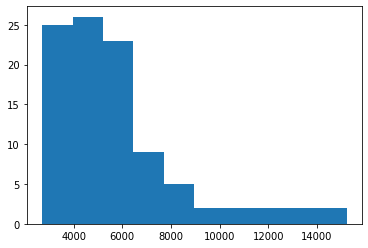

In [29]:
print(f'Mean:{covid_var.mean()}\nMedian:{covid_var.median()}\nStd.dev:{covid_var.std()}')
plt.hist(covid_var)

As we can see, while mean and median values are relatively close, standard deviation is not relatively small compared to mean.\
Although histogram does not look like a bell-shaped,we should know that, these results are not enough to decide the distribution.

In [30]:
shapiro_test = stats.shapiro(covid_var)
shapiro_p_value = shapiro_test.pvalue

ks_test = stats.kstest(covid_var, 'norm')
ks_p_value = ks_test.pvalue

print("Shapiro-Wilk test p-value:", shapiro_p_value)
print("Kolmogorov-Smirnov test p-value:", ks_p_value)

Shapiro-Wilk test p-value: 1.1643664921123786e-09
Kolmogorov-Smirnov test p-value: 0.0


Both p values are less than 0.05, thus we can say that the data is not normally distributed.

### Correlation Analysis

Now, we will implement some correlation analysis methods:
- Pearson Correlation Coefficient:

Measures the linear correlation between two continuous variables. It assesses the strength and direction of the linear relationship between variables. This method is suitable for normally distributed data.

- Spearman's Rank Correlation:

Assesses the strength and direction of monotonic relationships between variables. It does not assume linearity and is suitable for ordinal or non-normally distributed data.It calculates the correlation based on the ranks of the data rather than the actual values, making it more robust to outliers.Particularly useful when the relationship between variables might not be linear.

- Kendall's Tau:

Another method to measure the ordinal association between two measured quantities. Like Spearman's, Kendall's Tau is used when variables may have a non-linear relationship.It computes the correlation based on the number of concordant and discordant pairs of data points.

- Distance Correlation:

Measures the dependence between two random variables or datasets without assuming a linear relationship. It captures both linear and non-linear associations between variables.Useful when traditional methods like Pearson's correlation may miss non-linear relationships.

- Cross-Correlation Analysis:

Specifically used in time-series analysis to identify lagged correlations between two time-dependent variables. It helps in understanding if changes in one variable precede or follow changes in the other.

- Partial Correlation:

Measures the relationship between two variables while controlling for the influence of other variables. It helps determine the direct relationship between two variables after accounting for the effects of other variables.

In [31]:
df = merged_df.copy()
df['Date']= pd.to_datetime(df['Date'])
numer =df.drop(columns=['Date','Country'])

pearson_corr = df.corr()['New_cases']

spearman_corr = df.corr(method='spearman')['New_cases']

kendall_tau = df.corr(method='kendall')['New_cases']

def dist_corr(X, Y):
    return correlation(X, Y)

# Calculate partial correlation
partial_corr_results = {}
for col in numer.columns:
    if col != 'New_cases':
        covar_cols=numer.drop(columns=['New_cases', col])
        partial_corr_results[col] = pg.partial_corr(numer, x='New_cases', y=col, covar=list(covar_cols.columns),method='spearman')


Now, let us analyse the results:

In [32]:
print(f"Pearson's Correlation:\n{pearson_corr}")

Pearson's Correlation:
New_cases            1.000000
dew_value           -0.033777
humidity_value       0.022520
pm25_value          -0.127448
pressure_value      -0.059989
temperature_value   -0.035714
wind-speed_value    -0.009947
Name: New_cases, dtype: float64


We already know that Pearson's method is not suitable for our dataset as it is not normally distributed.Also there is no significant relationship between new cases and other measures, there is just a really weak negative relationship between most of them as still close to zero. 

In [33]:
print(f"Spearman's Rank Correlation:\n{spearman_corr}")

Spearman's Rank Correlation:
New_cases            1.000000
dew_value           -0.061132
humidity_value      -0.047568
pm25_value          -0.064328
pressure_value      -0.150744
temperature_value   -0.053165
wind-speed_value    -0.035061
Name: New_cases, dtype: float64


As we can see from results, the strongest negative relationship with new cases is pressure value, which makes sence because low air pressure means more wind and moving air which can carry bacterias.

In [34]:
print(f"Kendall's Tau:\n{kendall_tau}")

Kendall's Tau:
New_cases            1.000000
dew_value           -0.040945
humidity_value      -0.032425
pm25_value          -0.050969
pressure_value      -0.104114
temperature_value   -0.034942
wind-speed_value    -0.023193
Name: New_cases, dtype: float64


Again,the strongest relationship with new cases is pressure value and it is negative.

In [35]:
measures=numer.drop(columns=['New_cases'])
for k in measures.columns:
    print(f"Distance Correlation between New cases and {k} : {dist_corr(df['New_cases'], df[k])}")


Distance Correlation between New cases and dew_value : 1.0337768569676393
Distance Correlation between New cases and humidity_value : 0.9774799469560498
Distance Correlation between New cases and pm25_value : 1.1274476781354879
Distance Correlation between New cases and pressure_value : 1.0599888410598868
Distance Correlation between New cases and temperature_value : 1.0357140423932605
Distance Correlation between New cases and wind-speed_value : 1.0099467922598113


In a range of 0-2, 0 means perfect correlation, 2 means perfect negative correlation and 1 means no correlation. We can conclude that there is a slight positive correlation between new cases and pm25 value.

In [36]:
for col, result in partial_corr_results.items():
    print(f"Partial correlation between New_cases and {col}: {result['r']} (p-value: {result['p-val']})")

Partial correlation between New_cases and dew_value: spearman    0.014458
Name: r, dtype: float64 (p-value: spearman    0.201717
Name: p-val, dtype: float64)
Partial correlation between New_cases and humidity_value: spearman   -0.091461
Name: r, dtype: float64 (p-value: spearman    5.831697e-16
Name: p-val, dtype: float64)
Partial correlation between New_cases and pm25_value: spearman   -0.093582
Name: r, dtype: float64 (p-value: spearman    1.218400e-16
Name: p-val, dtype: float64)
Partial correlation between New_cases and pressure_value: spearman   -0.185103
Name: r, dtype: float64 (p-value: spearman    4.563757e-61
Name: p-val, dtype: float64)
Partial correlation between New_cases and temperature_value: spearman   -0.039035
Name: r, dtype: float64 (p-value: spearman    0.000565
Name: p-val, dtype: float64)
Partial correlation between New_cases and wind-speed_value: spearman   -0.083707
Name: r, dtype: float64 (p-value: spearman    1.319852e-13
Name: p-val, dtype: float64)


We can conclude from results that the strongest correlation with covid cases is pressure value. While there is really slight negative relationship between them,  p value, suggests strong evidence against the null hypothesis. In this case, we might conclude that there is a statistically significant correlation between covid cases and air pressure.(We should also remind that we used Spearman method for partial correlation analysis, it also affects the results.)

## Visualization

### Time Series Visualization

In [37]:
g_by_date=merged_df.groupby('Date').mean()

In [38]:
g_by_date

,New_cases,dew_value,humidity_value,pm25_value,pressure_value,temperature_value,wind-speed_value
Date,,,,,,,
2020-12-28,4852.298701,4.919640,72.959615,69.323194,995.719804,10.059639,3.434959
2020-12-29,5222.103896,5.499979,74.306452,68.914022,992.721711,10.335701,3.008254
2020-12-30,5846.215190,5.410292,75.500923,74.960928,999.347283,10.144236,2.836240
2020-12-31,7478.734177,4.971999,75.423331,80.792890,1000.566063,9.613650,2.613641
2021-01-01,7608.746835,4.921615,76.904889,88.739985,1001.614468,9.218000,2.457051
...,...,...,...,...,...,...,...
2021-03-31,4975.025000,8.095007,62.853186,69.132262,1005.988580,16.254768,2.920968
2021-04-01,5947.271605,7.943181,62.669331,68.447264,1002.884373,16.049805,3.239179
2021-04-02,6252.469136,7.644460,63.045605,63.214816,1000.514274,15.572192,3.279384


In [39]:
g_by_date.columns

Index(['New_cases', 'dew_value', 'humidity_value', 'pm25_value',
       'pressure_value', 'temperature_value', 'wind-speed_value'],
      dtype='object')

In [40]:
cols_to_compared=g_by_date.columns.delete([0])
cols_to_compared

Index(['dew_value', 'humidity_value', 'pm25_value', 'pressure_value',
       'temperature_value', 'wind-speed_value'],
      dtype='object')

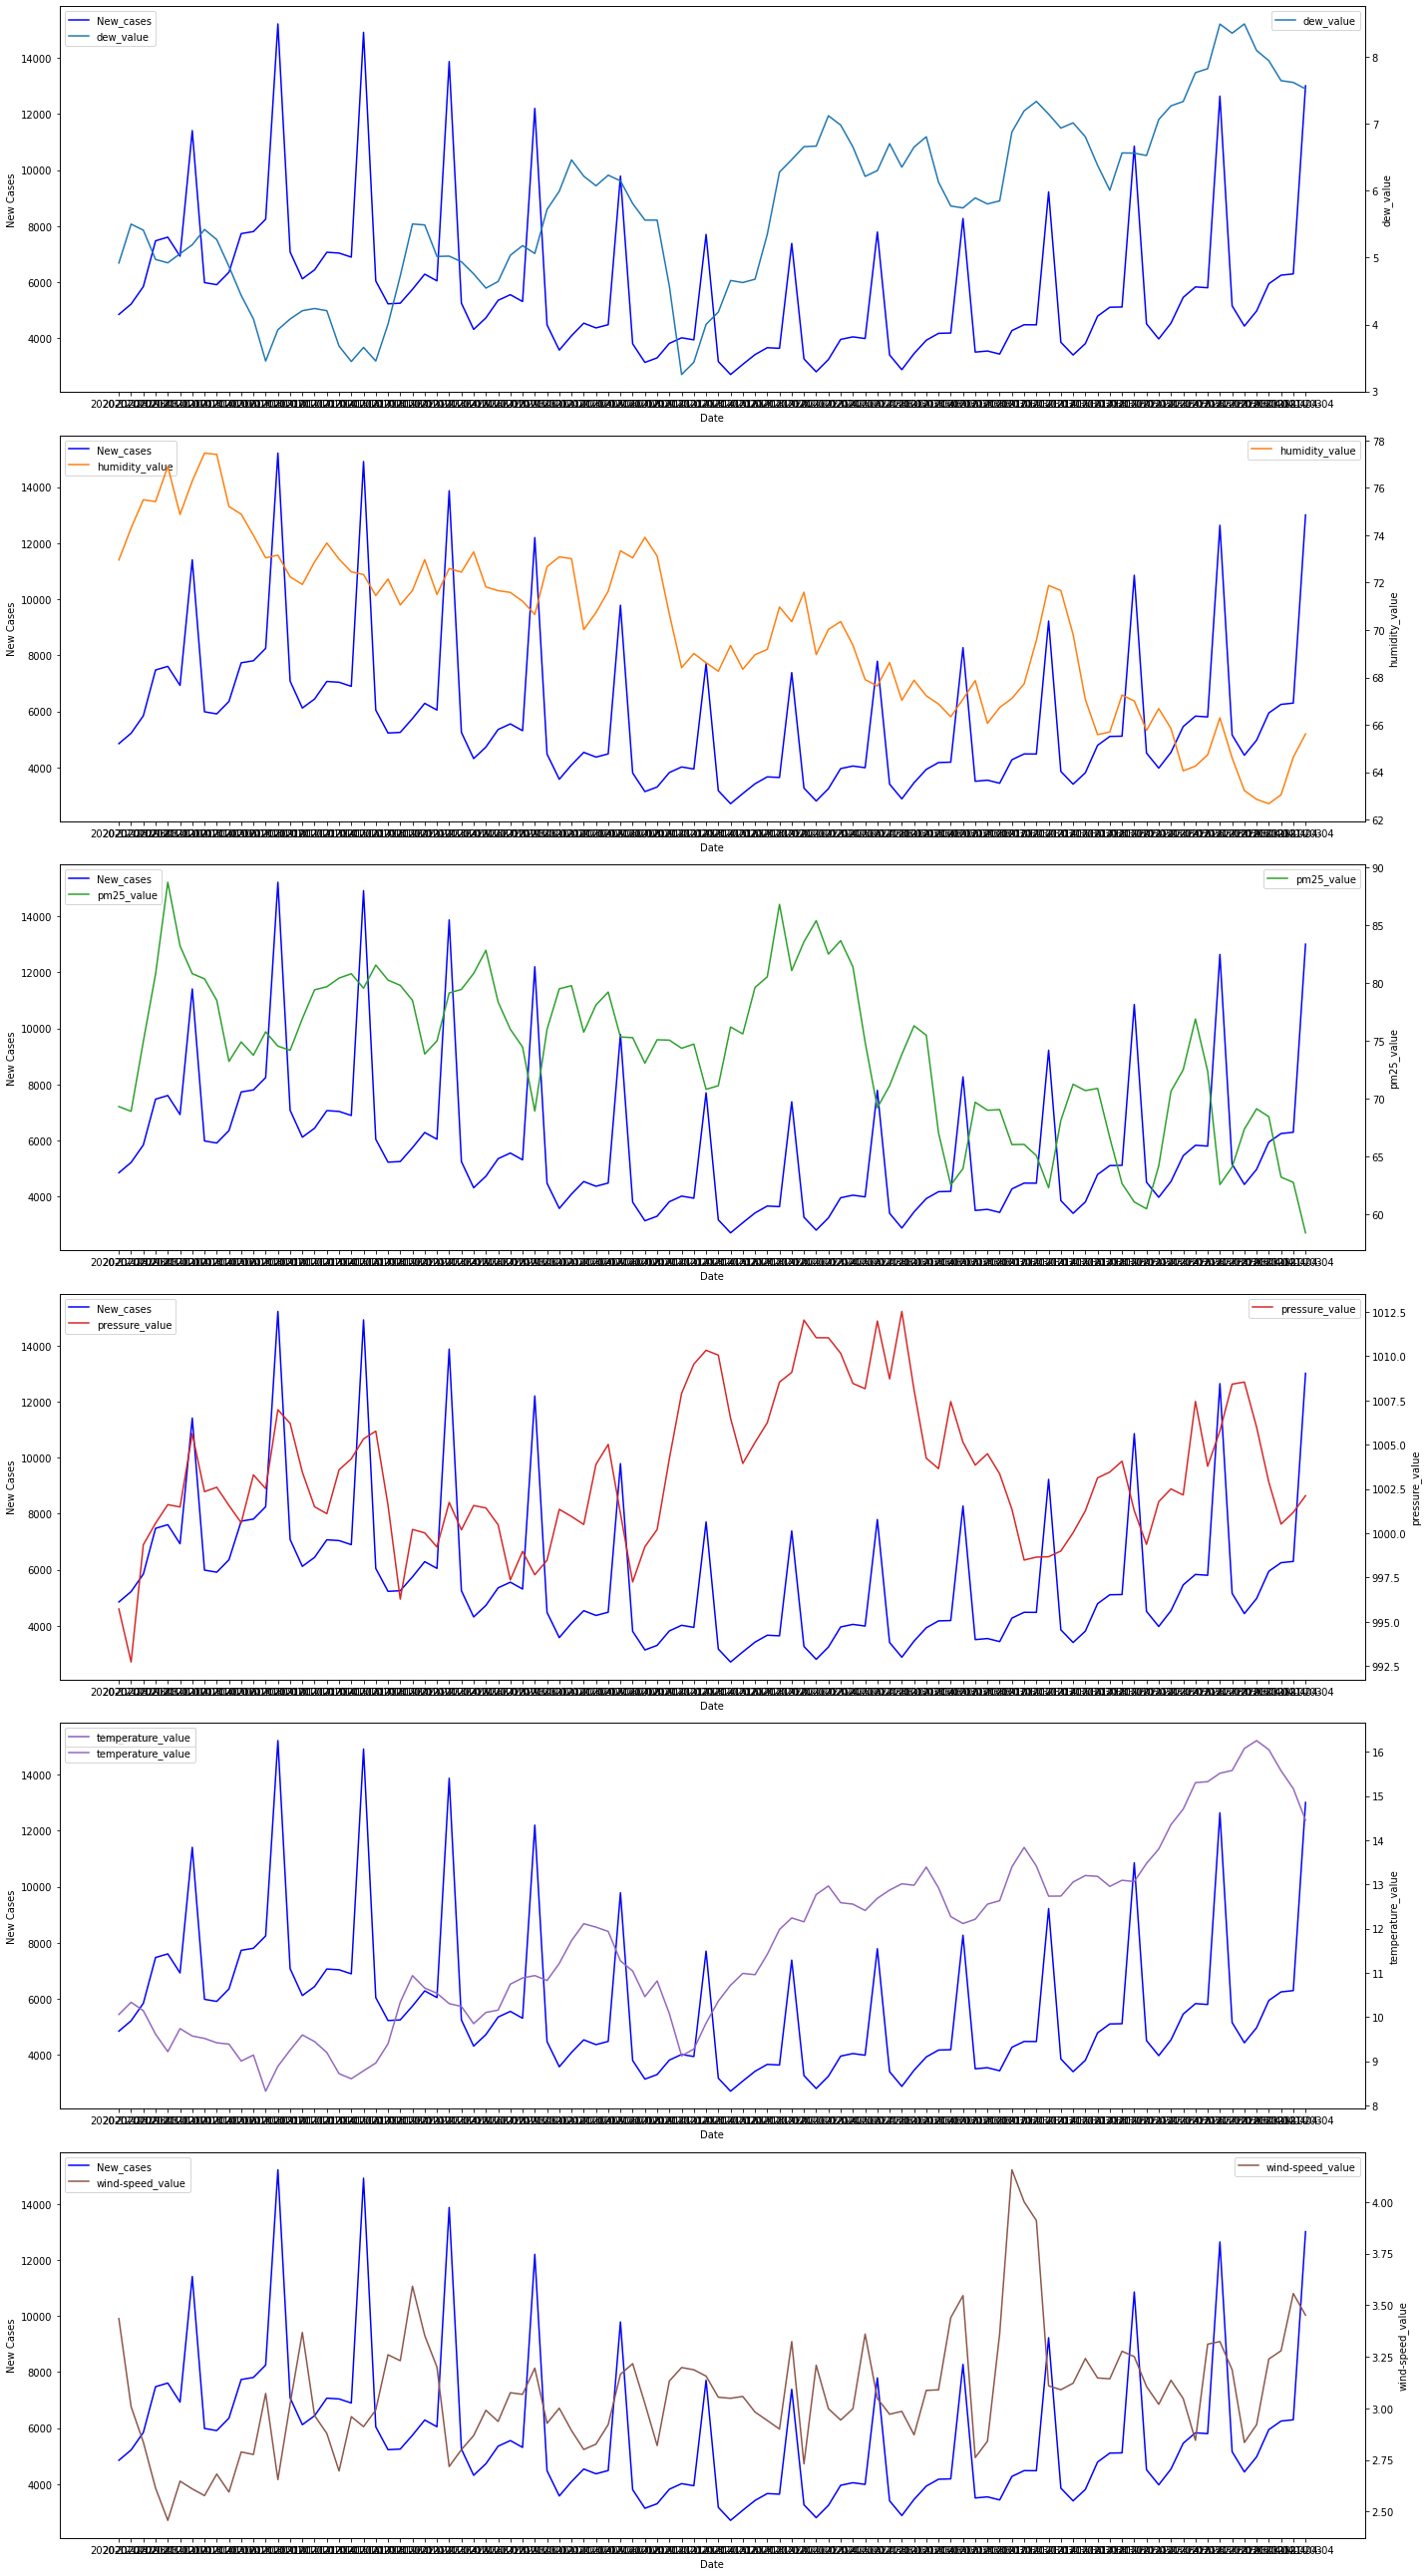

In [41]:
def plot_subplots(df, columns):
    num_plots = len(columns)
    palette = sns.color_palette('tab10', num_plots)  # Using Seaborn's 'tab10' palette for colors

    fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(20, 6*num_plots))

    for i, col in enumerate(columns):
        ax = axes[i] if num_plots > 1 else axes
        ax.set_xlabel('Date')
        ax.set_ylabel('New Cases')

        # Plot 'New_cases' on the primary y-axis
        sns.lineplot(data=df, x='Date', y='New_cases', ax=ax, label='New_cases', color='blue')

        # Create secondary y-axis for the specific column
        ax2 = ax.twinx()
        sns.lineplot(data=df, x='Date', y=col, ax=ax2, label=col, color=palette[i])
        ax2.set_ylabel(f'{col}')

        # Display legends for both plots
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines = lines1 + lines2
        labels = labels1 + labels2
        ax.legend(lines, labels, loc='upper left')

    plt.tight_layout()
    plt.show()

plot_subplots(g_by_date, cols_to_compared)

At the first sight, it looks line there is no significant behavior of parameters similar to new cases in time series but we should consider that air values may not immediately affect the new cases.\
\
As we can see, the new cases data has a cyclic behavior. Although no other parameter has a cyclic behavior, we canintuit some of the following consequences:\
When we look at the dew value vs new cases, there might be a bit inverse correlation between them.\
We can we look at the pressure values vs new cases, we can slightly notice the negative  behavior in the middle parts.

### Visualization of Correlation Analysis Based on Locations

In [42]:
package = Package('https://datahub.io/core/geo-countries/datapackage.json')

# print list of all resources:
#print(package.resource_names)

resources = package.descriptor['resources']
#for idx, resource in enumerate(resources):
    #print(f"Resource {idx + 1}: {resource['name']} - {resource['format']}")

# Choose the resource containing the GeoJSON data
resource_index = 2

resource_url = package.descriptor['resources'][resource_index]['path']

geo_data = gpd.read_file(resource_url)


In [43]:
geo_data.head()

,ADMIN,ISO_A3,geometry
0,Aruba,ABW,"POLYGON ((-69.99694 12.57758, -69.93639 12.531..."
1,Afghanistan,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903..."
2,Angola,AGO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -..."
3,Anguilla,AIA,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ..."
4,Albania,ALB,"POLYGON ((19.74777 42.57890, 19.74601 42.57993..."


In geo data, countries defined with their ISO_A3 code, thus it is converted  country codes:

In [44]:
based_loc_c = merged_df.groupby('Country').mean()
based_loc_c.index

Index(['AE', 'AF', 'AR', 'AT', 'AU', 'BA', 'BD', 'BE', 'BH', 'BR', 'CA', 'CH',
       'CI', 'CL', 'CN', 'CO', 'CW', 'CY', 'CZ', 'DE', 'DZ', 'EC', 'EE', 'ES',
       'ET', 'FI', 'FR', 'GB', 'GE', 'GH', 'GN', 'GR', 'GT', 'HR', 'HU', 'ID',
       'IL', 'IN', 'IQ', 'IR', 'IS', 'IT', 'JP', 'KG', 'KR', 'KZ', 'LA', 'LK',
       'LT', 'MK', 'ML', 'MM', 'MN', 'MX', 'NL', 'NO', 'NP', 'NZ', 'PH', 'PK',
       'PL', 'PT', 'RE', 'RO', 'RS', 'RU', 'SA', 'SE', 'SG', 'SK', 'SV', 'TH',
       'TJ', 'TM', 'TR', 'UA', 'UG', 'US', 'UZ', 'VN', 'XK', 'ZA'],
      dtype='object', name='Country')

In [45]:
country_code_dict={}
for country_code in based_loc_c.index:
    try:
        country = pycountry.countries.get(alpha_2=country_code)
        if country:  # Check if country object is found
            country_code_dict[country_code] = country.alpha_3
        else:
            print(f"Country code {country_code} not found in pycountry data.")
    except KeyError:
       print(f"Country code {country_code} not found.")

Country code XK not found in pycountry data.


In [46]:
country_code_dict['XK']='CRI' # added missing one

In [47]:
filtered_geo=geo_data[geo_data['ISO_A3'].isin(country_code_dict.values())]

In [48]:
for k,v in country_code_dict.items(): # countries which is in data, but not in geo 
    if (any(k in x  for x in based_loc_c.index)) & (~any(v in y for y in filtered_geo['ISO_A3'])):
        print(f"{k}:{v}")

RE:REU


As we dont have the geo information, we will delete this country:

In [49]:
based_loc_c.drop('RE',inplace=True) 


Updated country codes with ISO codes:

In [50]:
based_loc_c.index = based_loc_c.index.map(country_code_dict)

In [51]:
filtered_geo.rename(columns={'ISO_A3':'Country'},inplace=True)
filtered_geo.drop('ADMIN',axis=1,inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_29972\3075161201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_geo.rename(columns={'ISO_A3':'Country'},inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_29972\3075161201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_geo.drop('ADMIN',axis=1,inplace=True)


In [52]:
filtered_geo

,Country,geometry
1,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903..."
7,ARE,"MULTIPOLYGON (((53.86305 24.23469, 53.88860 24..."
8,ARG,"MULTIPOLYGON (((-68.65412 -54.88624, -68.65414..."
15,AUS,"MULTIPOLYGON (((158.86573 -54.74993, 158.83823..."
16,AUT,"POLYGON ((15.16179 48.93722, 15.23807 48.95076..."
...,...,...
235,UKR,"MULTIPOLYGON (((29.80747 45.61433, 29.73097 45..."
238,USA,"MULTIPOLYGON (((-155.60652 20.13796, -155.5863..."
240,UZB,"MULTIPOLYGON (((71.75730 39.90310, 71.74180 39..."
246,VNM,"MULTIPOLYGON (((106.66871 8.75349, 106.66586 8..."


Merge df that contains covid/air data and geo data

In [53]:
cases_geo=pd.merge(filtered_geo,based_loc_c,on='Country')

In [54]:
cases_geo

,Country,geometry,New_cases,dew_value,humidity_value,pm25_value,pressure_value,temperature_value,wind-speed_value
0,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903...",49.298969,-5.639175,45.745361,148.412371,1020.567010,6.061856,2.113402
1,ARE,"MULTIPOLYGON (((53.86305 24.23469, 53.88860 24...",2725.826531,12.844898,56.790816,84.086735,1014.762755,22.770408,2.690306
2,ARG,"MULTIPOLYGON (((-68.65412 -54.88624, -68.65414...",8817.714286,20.540816,76.240816,36.346939,1010.718367,22.555102,2.739796
3,AUS,"MULTIPOLYGON (((158.86573 -54.74993, 158.83823...",10.734694,14.401892,70.218952,17.562647,1010.723840,20.964564,3.344156
4,AUT,"POLYGON ((15.16179 48.93722, 15.23807 48.95076...",2050.510204,-1.797092,73.887347,55.346939,1002.962653,2.667143,2.246531
...,...,...,...,...,...,...,...,...,...
76,UKR,"MULTIPOLYGON (((29.80747 45.61433, 29.73097 45...",7403.051020,-2.951180,94.942562,58.347323,835.464504,1.695268,3.078237
77,USA,"MULTIPOLYGON (((-155.60652 20.13796, -155.5863...",117262.377551,-0.017489,66.105636,31.848985,1018.068192,7.259727,3.163086
78,UZB,"MULTIPOLYGON (((71.75730 39.90310, 71.74180 39...",24.428571,-0.765306,64.489796,112.153061,1021.862245,6.086735,2.463265
79,VNM,"MULTIPOLYGON (((106.66871 8.75349, 106.66586 8...",12.153061,17.634337,81.429847,54.918537,1009.478980,21.139541,2.055663


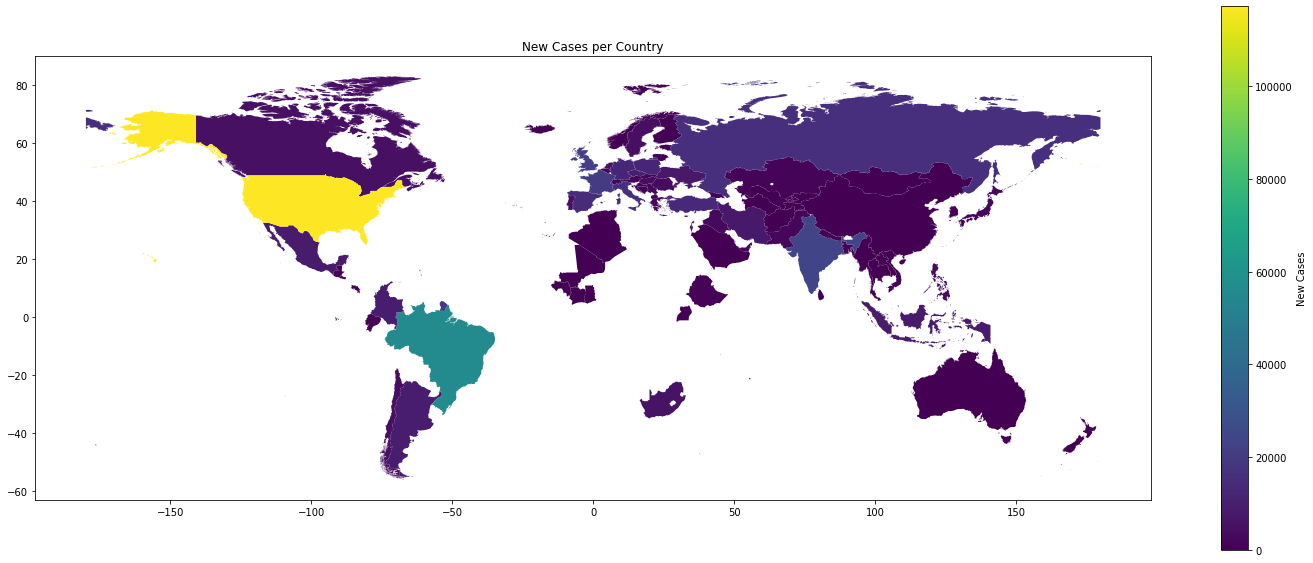

In [55]:
gdf = gpd.GeoDataFrame(cases_geo, geometry='geometry')

# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
gdf.plot(column='New_cases', ax=ax, legend=True, legend_kwds={'label': "New Cases"})

plt.title('New Cases per Country')
plt.show()

When we examine the map, we understand that the highest number of cases is in the North America continent. It is especially high in the USA. But we should consider that factors such as area size, population, etc. will also affect this result.\
When we look at the South American, Brazil stands out. This may also be due to the high population and surface area.\
We know that Covid first appeared in China and there were really high number of cases. Despite this, its value on the map is low. This may be due to the precautions they took.

Now, we will also plot the other parameters in order to analyse their behavior based on location:

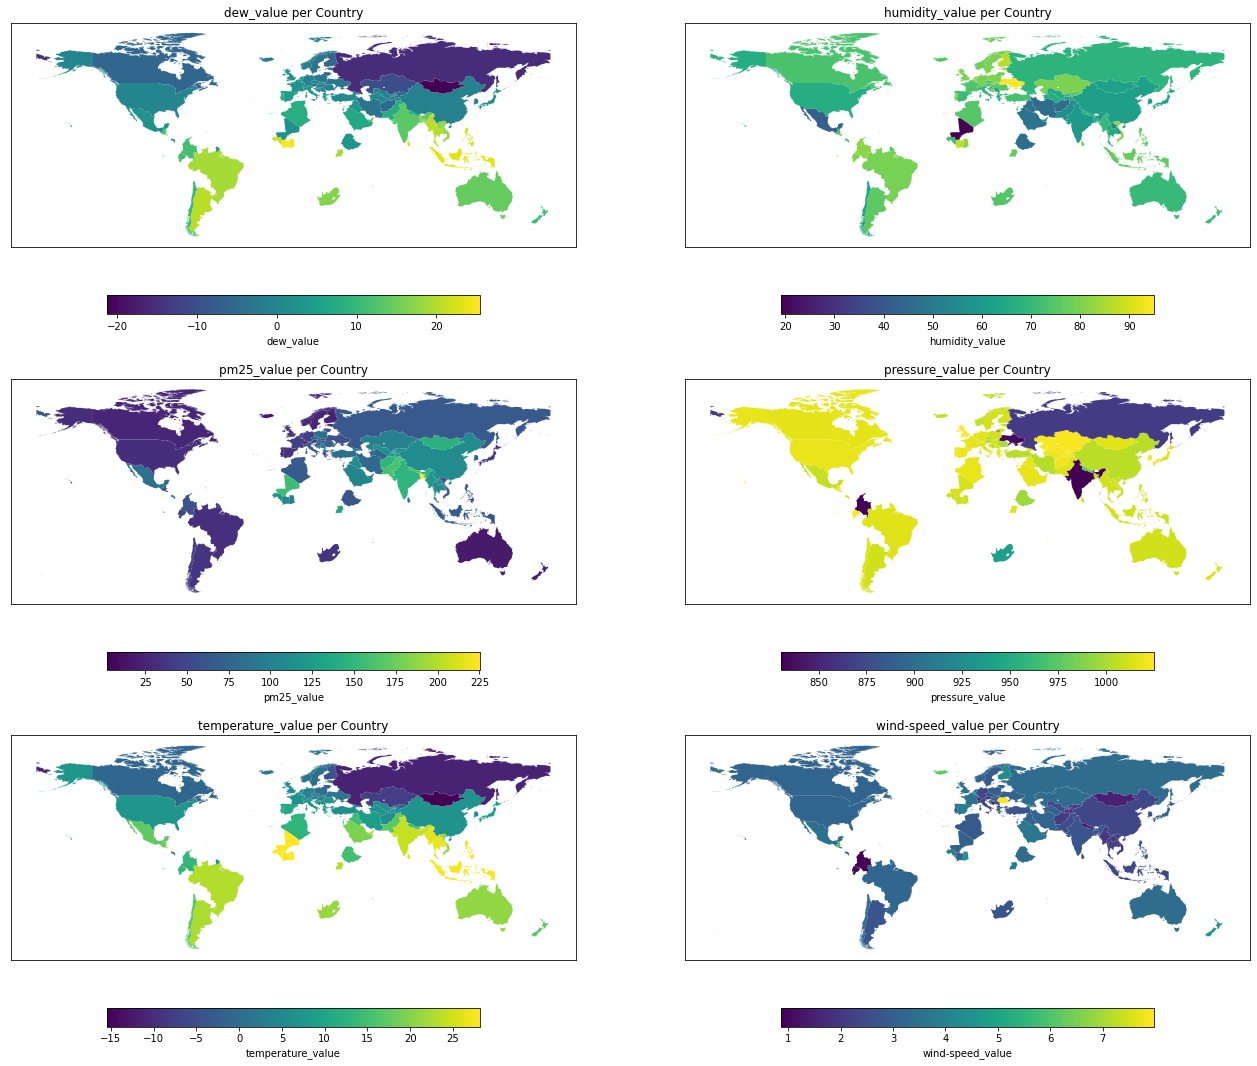

In [56]:
# Define the columns you want to plot
columns_to_plot = ['dew_value', 'humidity_value', 'pm25_value', 'pressure_value', 'temperature_value', 'wind-speed_value']

# Create a figure and an array of subplots
fig, axes = plt.subplots(len(columns_to_plot)//2, 2, figsize=(20, 15))

# Flatten the axes array to iterate through the subplots
axes = axes.flatten()

# Plotting each subplot for the selected columns
for i, column in enumerate(columns_to_plot):
    ax = axes[i]
    
    # Plotting the GeoDataFrame for the current column
    gdf.plot(column=column, ax=ax, legend=True, legend_kwds={'label': column, 'orientation': 'horizontal', 'shrink': 0.5})
    
    # Set subplot title
    ax.set_title(f'{column} per Country')
    
    # Remove x and y axis labels/ticks for cleaner presentation
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

We previously see that in USA,Brazil and Europe new cases are higher. Now we will try to find any similar behavior in other parameters:
* For dew values, we can see that dew levels are higher in the southern parts of the world.For the Europe, we can talk about a slight negative correlation but we can not say the same thing for USA and Brazil.
* There is no visible behavior in humidity value.
* For pm 2.5 values, we were previously thinking that there might be a positive correlation between them.Unfortunately, we cannot say the same for location based behavior. pm 2.5 values are lower in the west side of the world where USA and Brazil are close. Thus, We could not get any results confirming what we said before.
* For the pressure value, the high pressure in the west gives the impression of a negative relationship when focusing on America and Brazil, while the low value in Russia for Europe causes uncertainty about the situation.
* For the temperature values, it is higher in the south as we expected. Except for Brazil, we can say that there might be negative relationship between temperature and new cases.
* There is no visible behavior in wind speed value.



In [57]:
end_time = time.time()
execution_time = end_time - start_time

## Conclusion

In conclusion, we could not find a parameter that we could claim to have a strong correlation between the air quality values and the number of cases. In addition, we can say that there are low negative/positive correlations with some parameters. As we mentioned before, case numbers can be affected by vaccination rates, public health measures, population density, immunity levels, healthcare system capacity and many factors.

### Evaluation of what has been achieved
The aim of the project was answering the following questions:

1. Is there a possible or actual association between the air quality metrics and the data of COVID-19 cases?
2. Does the frequency of COVID-19 cases in a country have a significant correlation with the air quality measures that indicate the quality of the air at places at the national level?


* For the first question, we started by making distribution analysis in order to understand the stucture/behavior of the data. After that, we use various correlation analysis methods to find any association between air quality metrics and covid cases data. 
    * Difficulties:
        * Missing values: In air quality dataset, there are huge amount of missing values. Thus, we had to eliminate some of metrics which narrowed the scope of the project.
        * Analysis methods: As we were inexperienced and did not have basic knowledge on statistical analysis, we had some difficulties while implementing the method which we metioned in proposal.By doing extensive research on the necessary subjects, we learned how to use them and what the coefficients/values could mean.
* For the second question, we used a geojson file to see the data distribution over the world. Then, we merged the necessary data and visualize the corresponding dataframes in order to have an insight about similarities of distribution of air quality metrics and number of cases.
    * Difficulties:
        * Visualization: As we have a time info, we wanted to visualize them on a time period. For this purpose, we searched various visualization libraries. Plotly was one of them. We tried to visulize the data with interactive time frame(i.e. https://www.datacamp.com/tutorial/making-map-in-python-using-plotly-library-guide) or by subplots(i.e. https://plotly.com/python/map-subplots-and-small-multiples/)but we got errors and gave up.

### Time and resource analysis

In [58]:
print(f"Execution time: {execution_time} seconds")

Execution time: 57.997541427612305 seconds


In [59]:
num_cpus = psutil.cpu_count(logical=True)
print(f"Number of CPUs: {num_cpus}")

# Get CPU usage
cpu_usage = psutil.cpu_percent(interval=1)
print(f"CPU Usage: {cpu_usage}%")
print("--------------------------")
# Get memory information
memory = psutil.virtual_memory()
total_memory = memory.total / (1024 ** 3)  # Total memory in GB
available_memory = memory.available / (1024 ** 3)  # Available memory in GB

print(f"Total Memory: {total_memory:.2f} GB")
print(f"Available Memory: {available_memory:.2f} GB")
print("--------------------------")
disk_partitions = psutil.disk_partitions()
for partition in disk_partitions:
    partition_usage = psutil.disk_usage(partition.mountpoint)
    print(f"Partition: {partition.mountpoint}")
    print(f"Total: {partition_usage.total / (1024 ** 3):.2f} GB")
    print(f"Used: {partition_usage.used / (1024 ** 3):.2f} GB")
    print(f"Free: {partition_usage.free / (1024 ** 3):.2f} GB")
    print(f"Percentage Used: {partition_usage.percent}%")
    print("--------------------------")

Number of CPUs: 8


CPU Usage: 30.3%
--------------------------
Total Memory: 15.79 GB
Available Memory: 5.12 GB
--------------------------
Partition: C:\
Total: 237.86 GB
Used: 192.71 GB
Free: 45.15 GB
Percentage Used: 81.0%
--------------------------


In [60]:
# cpu_after = psutil.cpu_percent(interval=1)
# memory_after = psutil.virtual_memory().used
# disk_after = psutil.disk_usage(r'C:\Users\user\Desktop\OKUL\GUZ_23-24\MAT381-Introduction_to_datascience\MAT381-IntroductionToDataScience\final_project').used

# cpu_used = cpu_after - cpu_before
# memory_used = (memory_after - memory_before) / (1024 ** 3)  # Convert to GB
# disk_used = (disk_after - disk_before) / (1024 ** 3)  # Convert to GB

# print(f"CPU Used: {cpu_used}%")
# print(f"Memory Used: {memory_used:.2f} GB")
# print(f"Disk Space Used: {disk_used:.2f} GB")

CPU Used: -6.5%
Memory Used: 0.42 GB
Disk Space Used: -0.00 GB


(In case if you restart and run, output of code above:

Execution time: 57.997541427612305 seconds 

CPU Used: -6.5%\
Memory Used: 0.42 GB\
Disk Space Used: -0.00 GB)